In [ ]:
!pip install bayesian-optimization

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from bayes_opt import BayesianOptimization

Считываю и просматриваю набор данных

In [ ]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite', with_info=True, as_supervised=True)
train_summer = dataset['trainA']
train_winter = dataset['trainB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1231 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/incomplete.LGI8WG_3.0.0/cycle_gan-trainA.…

Generating trainB examples...:   0%|          | 0/962 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/incomplete.LGI8WG_3.0.0/cycle_gan-trainB.…

Generating testA examples...:   0%|          | 0/309 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/incomplete.LGI8WG_3.0.0/cycle_gan-testA.t…

Generating testB examples...:   0%|          | 0/238 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/incomplete.LGI8WG_3.0.0/cycle_gan-testB.t…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/3.0.0. Subsequent calls will reuse this data.


In [ ]:
# Функция для отображения изображений
def display_images(dataset, class_name, num_images=5):
    plt.figure(figsize=(10, 10)) # создаю фигуру с указанным размером, на которой будут размещены изображения
    for i, (image, _) in enumerate(dataset.take(num_images)): # выбираю первые num_images изображений из датасета
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(class_name)
    plt.show()

Summer images:


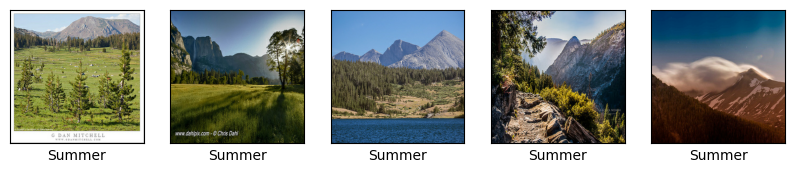

In [ ]:
class_names = ['Summer', 'Winter']
print("Summer images:")
display_images(train_summer, class_names[0])

Winter images:


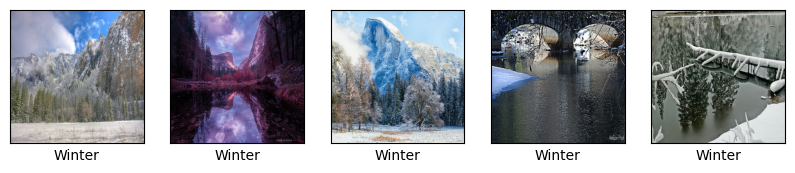

In [ ]:
print("Winter images:")
display_images(train_winter, class_names[1])

In [ ]:
# Функция для распределения классов и построения гистограммы
def class_distribution_and_plot(datasets, class_names):
    counts = [] # использую пустой массив для хранения кол-ва изображений в каждом классе
    for dataset in datasets: # перебираю каждый датасет в datasets
        count = 0
        for _ in dataset:
            count += 1
        counts.append(count)

    # Построение гистограммы
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, counts, color=['yellow', 'blue'])
    plt.xlabel('Классы')
    plt.ylabel('Количество изображений')
    plt.title('Распределение классов')
    plt.show()

    return counts

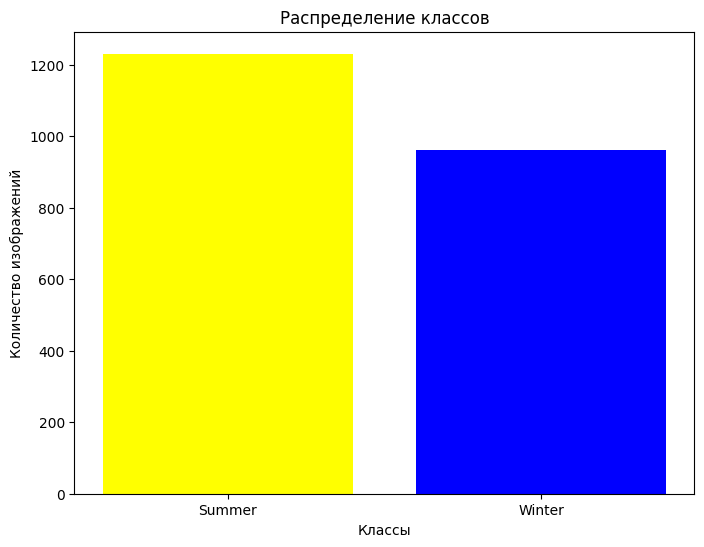

Количество летних фотографий: 1231
Количество зимних фотографий: 962


In [ ]:
class_names = ['Summer', 'Winter']
datasets = [train_summer, train_winter]
counts = class_distribution_and_plot(datasets, class_names)

print(f"Количество летних фотографий: {counts[0]}")
print(f"Количество зимних фотографий: {counts[1]}")

Летние изображения после предварительной обработки:


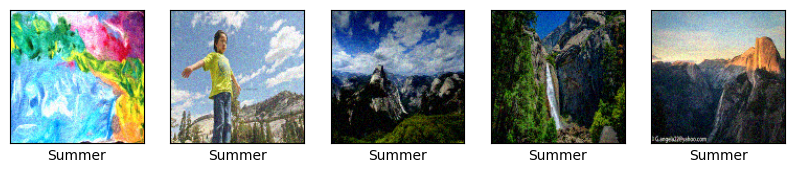

Зимние изображения после предварительной обработки:


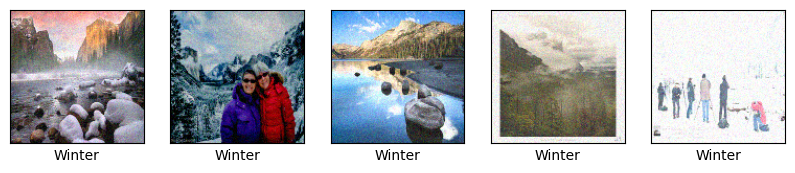

In [ ]:
# Добавление меток классам
train_summer = train_summer.map(lambda image, _: (image, 0))
train_winter = train_winter.map(lambda image, _: (image, 1))

# Функция для аугментации изображений
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # рандомно переворачиваю изображение по горизонтали с вероятностью 50%
    image = tf.image.random_brightness(image, max_delta=0.2) # рандомно изменяю яркость изображений
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # рандомно изменяю контраст изображений
    return image, label

# Аугментация изображений
train_summer = train_summer.map(augment)
train_winter = train_winter.map(augment)

# Объединение классов с балансировкой
dataset = tf.data.Dataset.sample_from_datasets([train_summer, train_winter], weights=[0.5, 0.5])

# Функция для нормализации и стандартизации размеров изображений
def normalize_and_resize(image, label):
    image = tf.image.resize(image, (128, 128)) # изменяю размер изображения до 128х128 пикселей
    image = tf.cast(image, tf.float32) / 255.0 # преобразую изоражение в тип float32 и нормализую значения пикселей
    image = tf.clip_by_value(image, 0.0, 1.0) # ограничиваю значения пикселей в диапазоне от 0 до 1, чтобы избежать выходов за границы
    return image, label

# Функция для добавления шума
def add_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32) # генерирую шум с нормальным распределением
    image = image + noise # добавляю шум к изображению
    image = tf.clip_by_value(image, 0.0, 1.0) # ограничиваю значения пикселей от 0 до 1
    return image, label

# Нормализация и стандартизация размеров
dataset = dataset.map(normalize_and_resize)

# Добавление шума
dataset = dataset.map(add_noise)

# Перемешивание данных
dataset = dataset.shuffle(buffer_size=1000)

horses_dataset_after = dataset.filter(lambda img, label: label == 0)
zebras_dataset_after = dataset.filter(lambda img, label: label == 1)

# Отображение летних изображений
print("Летние изображения после предварительной обработки:")
display_images(horses_dataset_after, class_names[0])

# Отображение зимних изображений
print("Зимние изображения после предварительной обработки:")
display_images(zebras_dataset_after, class_names[1])

In [ ]:
# Функция разделения датасета на обучающую и тестовую
def train_test_dataset(dataset, train_fraction=0.8):
    dataset = dataset.shuffle(buffer_size=1000) # перемешиваю данные в датасете с буфером размером 1000 элементов
    dataset_size = sum(1 for _ in dataset) # считаю общее кол-во изображений в датасете
    train_size = int(train_fraction * dataset_size) # вычисляет кол-во изображений для обучающей выборки
    train_dataset = dataset.take(train_size).batch(batch_size) # беру первые train_size изображений для обучающей выборки и группирую их в батчи
    test_dataset = dataset.skip(train_size).batch(batch_size) # пропускаю train_size изображений и беру оставшиеся для тестовой выборки, также группируя их в батчи
    return train_dataset, test_dataset

batch_size = 32

train_dataset, test_dataset = train_test_dataset(dataset)
train_batches = sum(1 for _ in train_dataset)
test_batches = sum(1 for _ in test_dataset)

print(f'Количество обучающих батчей: {train_batches}')
print(f'Количество тестовых батчей: {test_batches}')

Количество обучающих батчей: 55
Количество тестовых батчей: 14


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.5236 - loss: 3.6648 - val_accuracy: 0.6583 - val_loss: 0.6875
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - accuracy: 0.6482 - loss: 0.7879 - val_accuracy: 0.7198 - val_loss: 0.5481
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.6496 - loss: 0.7815 - val_accuracy: 0.6993 - val_loss: 0.6054
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.6708 - loss: 0.6644 - val_accuracy: 0.7380 - val_loss: 0.5394
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - accuracy: 0.6781 - loss: 0.7166 - val_accuracy: 0.7039 - val_loss: 0.6978
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.7110 - loss: 0.6232 - val_accuracy: 0.6629 - val_loss: 0.6534
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.7047 - loss: 0.5802 - val_accuracy: 0.6469 - val_loss: 0.6607
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.7110 - loss: 0.6197 - val_accu

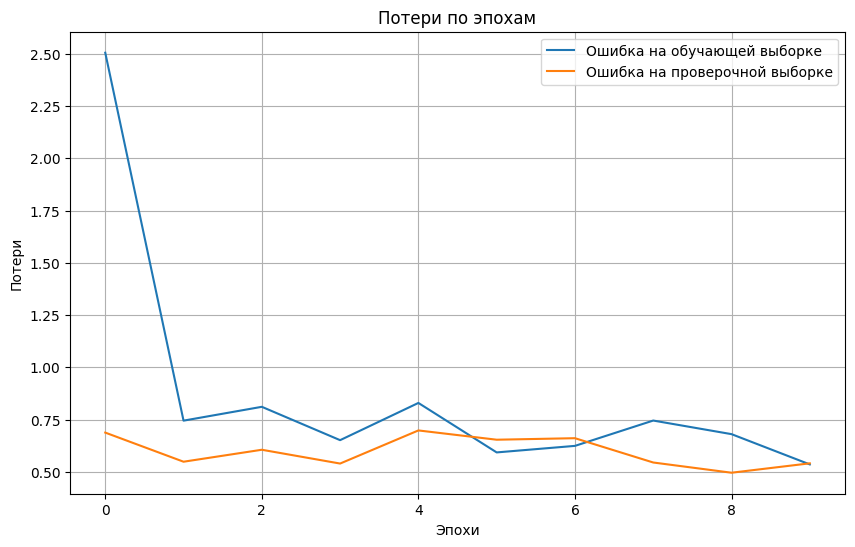

In [ ]:
model = models.Sequential([ # создаю последовательную модель, где слои добавляются друг за другом
    layers.Flatten(input_shape=(128, 128, 3)), # определяю форму выходных нейронов и преобразую входные данные из 3-х мерного массива в одномерный для того, чтобы данные могли быть обработаны полносвязными слоями (Dense)
    layers.Dense(128, activation='relu'), # полносвязный слой с 128 нейронами и функция активации ReLU, которая применяется к выходам нейронов
    layers.Dense(64, activation='relu'), # выходной слой с одним нейроном, что подходит для задачи бинарной классификации
    layers.Dense(1, activation='sigmoid') # использую сигмоидную функцию активации, которая сжимает выход в диапазон [0, 1], что полезно для предсказания вероятности принадлежности к классу
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # выбираю функцию потерь для бинарной классификации (она измеряет насколько хорошо модель предсказывает вероятности)
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset) # возвращает объект, содержащий историю обучения, включая потери и метрики на обучающем и валидационном наборах

train_loss, train_accuracy = model.evaluate(train_dataset)
print(f'Ошибка на обучающей выборке: {train_loss:.3f}, Точность(accuracy): {train_accuracy:.3f}')
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Ошибка на проверочной выборке: {test_loss:.3f}, Точность(accuracy): {test_accuracy:.3f}')

train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Ошибка на обучающей выборке')
plt.plot(val_loss_values, label='Ошибка на проверочной выборке')
plt.title('Потери по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Подбор гиперпараметров

def train_model(neurons1, neurons2, learning_rate):
    model = models.Sequential([
        Input(shape=(128, 128, 3)),
        layers.Flatten(),
        layers.Dense(int(neurons1), activation='relu'),
        layers.Dense(int(neurons2), activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,  # компилирую модель с заданными параметрами
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=4, verbose=0)
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    return accuracy

pbounds = {  # словарь, определяющий диапазоны для каждого гиперпараметра
    'neurons1': (64, 256), # количество нейронов в первом слое (от 64 до 256)
    'neurons2': (32, 128), # количество нейронов во втором слое (от 32 до 128)
    'learning_rate': (1e-5, 1e-2) # скорость обучения (от 1e-5 до 1e-2)
}

optimizer = BayesianOptimization( # использую байесовский оптимизатор для поиска лучших гиперпараметров
    f=train_model, # функция, которую нужно оптимизировать
    pbounds=pbounds, # границы для гиперпараметров
    verbose=2,  # вывожу результаты всех итераций
    random_state=1 # задаю начальное состояние
)

optimizer.maximize(init_points=5, n_iter=10)

best_params = optimizer.max['params']
print(f"Лучщие параметры: {best_params}")

|   iter    |  target   | learni... | neurons1  | neurons2  |
-------------------------------------------------------------
| 1         | 0.7084    | 0.004176  | 202.3     | 32.01     |
| 2         | 0.5581    | 0.00303   | 92.18     | 40.86     |
| 3         | 0.697     | 0.001871  | 130.3     | 70.09     |
| 4         | 0.7039    | 0.005393  | 144.5     | 97.78     |
| 5         | 0.5011    | 0.002052  | 232.6     | 34.63     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 6         | 0.6105    | 0.004364  | 201.8     | 33.36     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 7         | 0.6378    | 0.005328  | 215.2     | 48.79     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 8         | 0.6856    | 0.005962  | 114.1     | 103.7     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 9         | 0.7084    | 0.002283  | 93.87     | 122.9     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 10        | 0.5809    | 0.007265  | 203.9     | 50.69     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 11        | 0.7198    | 0.004708  | 145.3     | 77.3      |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 12        | 0.697     | 0.009555  | 191.5     | 77.19     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 13        | 0.6948    | 0.004892  | 225.5     | 126.0     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 14        | 0.4601    | 0.003232  | 210.6     | 114.3     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 15        | 0.6743    | 0.008551  | 202.1     | 119.5     |
Лучщие параметры: {'learning_rate': 0.004707764439853985, 'neurons1': 145.31060058210556, 'neurons2': 77.30361634946559}


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     55/Unknown 12s 93ms/step - accuracy: 0.5657 - loss: 20.8039

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.5657 - loss: 20.6273 - val_accuracy: 0.6082 - val_loss: 2.5417
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.6337 - loss: 1.7023 - val_accuracy: 0.6811 - val_loss: 0.7841
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.6302 - loss: 0.8828 - val_accuracy: 0.7107 - val_loss: 0.5660
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.6740 - loss: 0.6352 - val_accuracy: 0.6765 - val_loss: 0.6864
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.6610 - loss: 0.6764 - val_accuracy: 0.5968 - val_loss: 1.9043
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.5979 - loss: 1.0537 - val_accuracy: 0.6902 - val_loss: 0.5667
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - accuracy: 0.6767 - loss: 0.5919 - val_accuracy: 0.6720 - val_loss: 0.5940
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.6936 - loss: 0.6041 - val_accuracy: 0.63

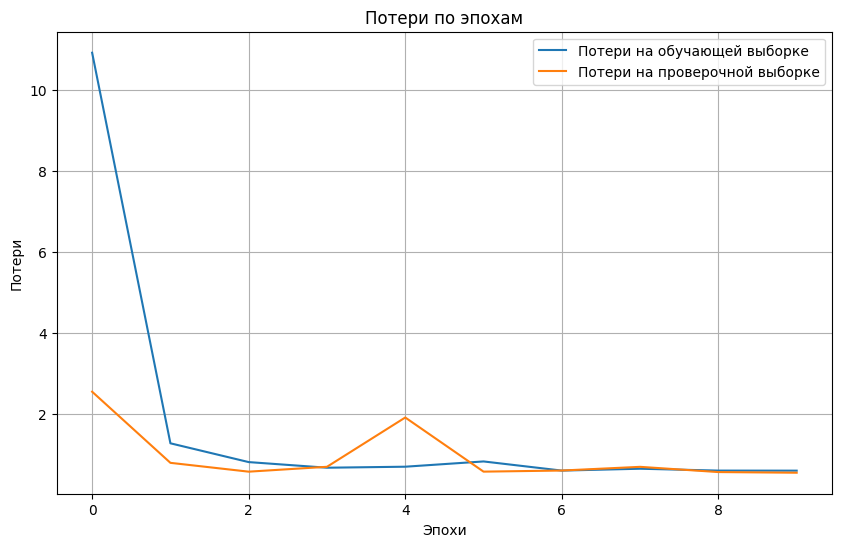

In [ ]:
best_params = optimizer.max['params']
neurons1 = int(best_params['neurons1'])
neurons2 = int(best_params['neurons2'])
learning_rate = best_params['learning_rate']

best_model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),
    layers.Dense(neurons1, activation='relu'),
    layers.Dense(neurons2, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

best_optimizer = Adam(learning_rate=learning_rate)
best_model.compile(optimizer=best_optimizer,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

best_history = best_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

best_train_loss, best_train_accuracy = best_model.evaluate(train_dataset)
print(f'Обучение с лучшими параметрами\n Потери(loss): {best_train_loss:.3f}, Точность(accuracy): {best_train_accuracy:.3f}')
best_test_loss, best_test_accuracy = best_model.evaluate(test_dataset)
print(f'Тестирование с лучшими параметрами\n Потери(loss): {test_loss:.3f}, Точность(accuracy): {test_accuracy:.3f}')

best_train_loss_values = best_history.history['loss']
best_val_loss_values = best_history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(best_train_loss_values, label='Потери на обучающей выборке')
plt.plot(best_val_loss_values, label='Потери на проверочной выборке')
plt.title('Потери по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
plt.show()